<h2 style="text-align: center;"><strong>Segment 3: Automatic Differentiation</strong></h2>

* AutoDiff with PyTorch and TensorFlow 2
* Machine Learning via Differentiation 

In [63]:
import matplotlib.pyplot as plt
import torch 
import tensorflow as tf

## **AutoDiff with PyTorch and TensorFlow 2**

**PyTorch** and **TensorFlow** are the two most popular automatic differentiation libraries.

Let's use them to calculate $dy/dx$ at $x = 5$ where: 

$$y = x^2$$

$$ \frac{dy}{dx} = 2x = 2(5) = 10 $$

##### **AutoDiff with PyTorch**

In [64]:
x = torch.tensor(5.0)
x

tensor(5.)

*Contagiously track gradients through forward pass*

In [65]:
x.requires_grad_() 

tensor(5., requires_grad=True)

In [66]:
y = x**2

*Using autodiff*

In [67]:
y.backward()

In [68]:
x.grad

tensor(10.)

##### **Autodiff with TensorFlow**

In [69]:
x = tf.Variable(5.0)

*Track forward pass*

In [70]:
with tf.GradientTape() as t:
    t.watch(x) 
    y = x**2

*Using autodiff*

In [71]:
t.gradient(y, x) 

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

---

## **Machine Learning via Differentiation**

*We use PyTorch’s automatic differentiation library to fit a straight line to a very small dataset containing only a few data points. This time, the regression problem is solved using auto-diff, rather than the* **Moore–Penrose pseudoinverse** *approach covered earlier in* **Phase 3, Course 3: Linear Algebra for Machine Learning.**

$x$ *represents the **dosage levels of a drug** administered to patients in a study on Alzheimer's disease.*

In [72]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.])
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

$y$ *represents the patients forgetfulness scores corresponding to each drug dosage.*

In [73]:
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) 
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

**Plot data points**

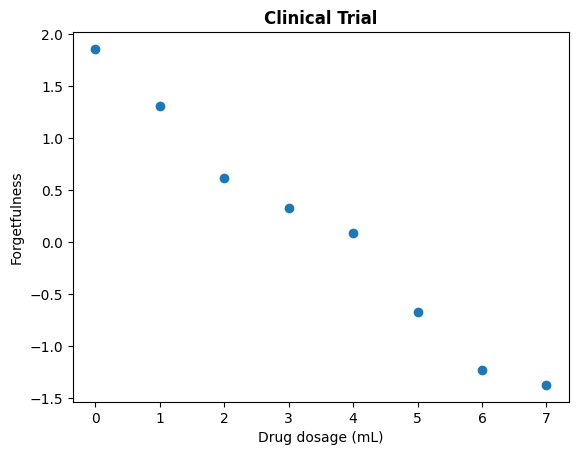

In [74]:
fig, ax = plt.subplots()
plt.title("Clinical Trial",fontweight="bold")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
ax.scatter(x, y)
plt.show()

*The target $y$ values are generated from the linear equation $y = mx + b$, which lets us know the true parameters the model should learn. In our case, the underlying line uses $m = 0.9$ and $b = 0.1$. To introduce a bit of realism, we add random, normally distributed noise to the data to simulate sampling variability. We will use PyTorch’s automatic differentiation (autodiff) to learn these parameters from the noisy observations.*

In [75]:
m = torch.tensor(0.9, requires_grad=True)
m

tensor(0.9000, requires_grad=True)

In [76]:
b = torch.tensor(0.1, requires_grad=True)
b

tensor(0.1000, requires_grad=True)

*We define a simple regression function that computes the predicted value $\hat{y}$ for a given input $x$ using the linear model $y = mx + b$*

In [77]:
def regression(m,x,b):
    return m*x + b

*Function to Plot the Noisy Data and the Learned Linear Model*

In [78]:
def regression_plot(x, y, m, b):
    # Get current axes for plotting
    ax = plt.gca()  

    # Plot data points
    ax.scatter(x.detach().numpy(), y.detach().numpy(), label="Data", color='blue')  

    # Compute endpoints of the regression line
    x_min, x_max = x.min().item(), x.max().item()
    y_min, y_max = (m * x_min + b).item(), (m * x_max + b).item()
    # Plot regression line
    ax.plot([x_min, x_max], [y_min, y_max], color='red', label="Regression Line") 

    # Add labels, title, legend, and grid
    ax.set_xlabel("Drug dosage (mL)")
    ax.set_ylabel("Drug dosage (mL)")
    ax.set_title("Linear Regression",fontweight="bold")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)

    return ax

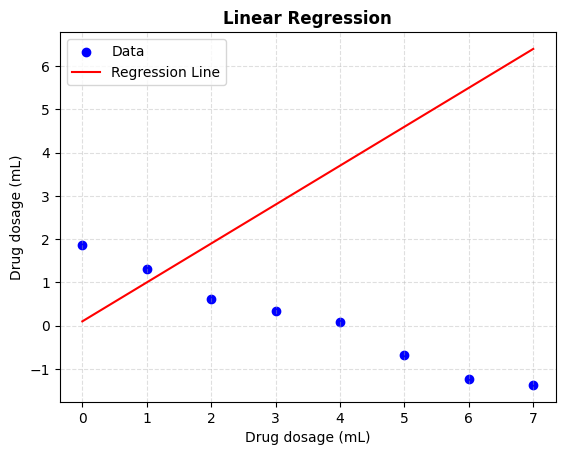

In [79]:
plt.show(regression_plot(x,y,m,b))

### **Model Training**

**Step 1**: Forward pass

In [80]:
yhat = regression(m,x,b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

> There is a PyTorch **MSELoss** method, but let's define it outselves to see how it works. MSE cost is defined by:* $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [81]:
def mse(yhat, y): 
    sigma = torch.sum((yhat - y)**2)
    return sigma/len(y)

In [82]:
C = mse(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Step 3**: Use Autodiff to calculate gradient of $C$ w.r.t. parameters

In [83]:
C.backward()

In [84]:
m.grad

tensor(36.3050)

In [85]:
b.grad

tensor(6.2650)

**Step 4**: Gradient descent

In [86]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [87]:
optimizer.step()

*Let's confirm parameters have been adjusted sensibly*

In [88]:
m

tensor(0.5369, requires_grad=True)

In [89]:
b

tensor(0.0374, requires_grad=True)

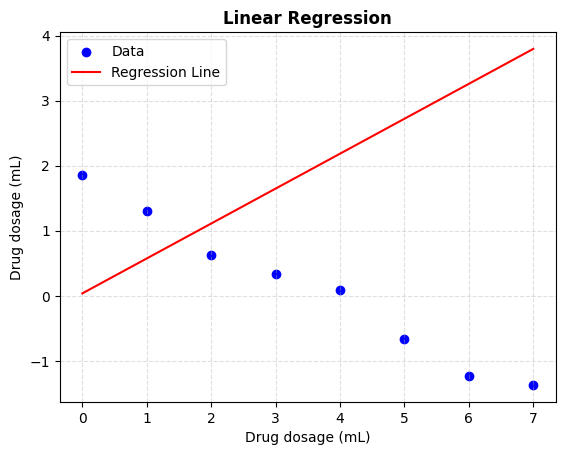

In [90]:
plt.show(regression_plot(x,y,m,b))

*We can repeat steps 1 and 2 to confirm cost has decreased*

In [91]:
C = mse(regression(m,x,b), y)
C

tensor(8.5722, grad_fn=<DivBackward0>)

*Put the 4 steps in a loop to iteratively minimize cost toward zero:*

In [92]:
epochs = 1000  # Total number of training iterations

for epoch in range(1, epochs + 1):
    # ------------------------------
    # Step 1: Zero gradients
    # ------------------------------
    # Gradients accumulate by default in PyTorch,
    # so we must reset them at the start of each iteration
    optimizer.zero_grad()

    # ------------------------------
    # Step 2: Forward pass
    # ------------------------------
    # Compute predicted values using current m and b
    yhat = regression(m, x, b)

    # ------------------------------
    # Step 3: Compute loss
    # ------------------------------
    # Mean Squared Error between prediction and actual y
    loss = mse(yhat, y)

    # ------------------------------
    # Step 4: Backward pass
    # ------------------------------
    # Compute gradients of loss w.r.t parameters m and b
    loss.backward()

    # ------------------------------
    # Step 5: Update parameters
    # ------------------------------
    # Optimizer updates m and b using the computed gradients
    optimizer.step()

    # ------------------------------
    # Step 6: Logging / Monitoring
    # ------------------------------
    # Print loss and gradients every 100 epochs
    if epoch % 100 == 0 or epoch == 1:
        print(
            f"Epoch {epoch}, loss: {loss.item():.4f}, m grad: {m.grad.item():.4f}, b grad: {b.grad.item():.4f}"
        )


Epoch 1, loss: 8.5722, m grad: 23.1597, b grad: 3.5984
Epoch 100, loss: 0.3467, m grad: 0.1224, b grad: -0.6020
Epoch 200, loss: 0.1224, m grad: 0.0687, b grad: -0.3376
Epoch 300, loss: 0.0519, m grad: 0.0385, b grad: -0.1894
Epoch 400, loss: 0.0297, m grad: 0.0216, b grad: -0.1062
Epoch 500, loss: 0.0227, m grad: 0.0121, b grad: -0.0596
Epoch 600, loss: 0.0205, m grad: 0.0068, b grad: -0.0334
Epoch 700, loss: 0.0198, m grad: 0.0038, b grad: -0.0187
Epoch 800, loss: 0.0196, m grad: 0.0021, b grad: -0.0105
Epoch 900, loss: 0.0195, m grad: 0.0012, b grad: -0.0059
Epoch 1000, loss: 0.0195, m grad: 0.0007, b grad: -0.0033


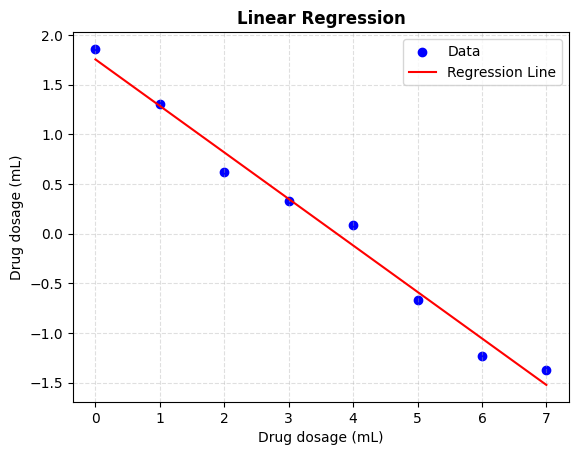

In [93]:
plt.show(regression_plot(x,y,m,b))

---